In [1]:
# Bibliotecas python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
%matplotlib inline

# Função para calcular moda.
from scipy import stats

# Formatação dos gráficos
from matplotlib.ticker import FuncFormatter
from matplotlib.legend import Legend

In [2]:
# Configurando o tema do gráfico
myrcs = {"axes.titleweight": "bold", "lines.markersize": 9.0, "lines.linewidth": 2.0,}
sns.set (style="whitegrid", font_scale=1.25, rc=myrcs)

# Linhas exibidas por padrão nos dataframes
pd.options.display.min_rows = 20

In [3]:
# Parâmetros que variam nesta simulação
seeds = [10,20]
cargas = ["5hosts", "10hosts"]

# Tempo total de simulação
t_sim = 2000

In [4]:
# Função para ler os arquivos de log
def mymode (series):
    return stats.mode (series)[0]

agg_map = {'SwAtivosAntes' : mymode, 'SwAtivosDepois' : mymode, 'AvgCPULoad' : np.mean}

def read_dataframe ():
    df_slc = []
    for carga in cargas:
        df_sed = []
        for seed in seeds:
            df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+carga+"-"+str(seed)+"-logDecisaoSwitchesSW.log", sep='\s+', index_col=["TimeSec"])
            df_sed.append (df)
        df_slc.append (pd.concat (df_sed).groupby (["TimeSec"]).agg (agg_map))
    df_read = pd.concat (df_slc, keys=cargas, names=["Carga"], copy=False)
    return df_read.reset_index ()

In [5]:
df_plot = read_dataframe()
df_plot

,Carga,TimeSec,SwAtivosAntes,SwAtivosDepois,AvgCPULoad
0,5hosts,15.0,1,1,0.0125
1,5hosts,30.0,1,1,0.0255
2,5hosts,45.0,1,1,0.0140
3,5hosts,60.0,1,1,0.0250
4,5hosts,75.0,1,1,0.0190
5,5hosts,90.0,1,1,0.0290
6,5hosts,105.0,1,1,0.0170
7,5hosts,120.0,1,1,0.0395
8,5hosts,135.0,1,1,0.0120
9,5hosts,150.0,1,1,0.0340


In [6]:
df_hw = []
agg_maphw = {'LoaUsag' : np.mean, 'FloUsag' : np.mean, 'FloEntr' : np.mean,'LoaKbps' : mymode}
for carga in cargas:
    df_sed = []
    for seed in seeds:
        df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+carga+"-"+str(seed)+"-switch-stats-hw.log", sep='\s+', index_col=["TimeSec"])
        df_sed.append (df)
    df_hw.append (pd.concat (df_sed).groupby (["TimeSec"]).agg (agg_maphw))
df_hwstats = pd.concat (df_hw, keys=cargas, names=["Carga"], copy=False)
df_hwstats = df_hwstats.reset_index ()

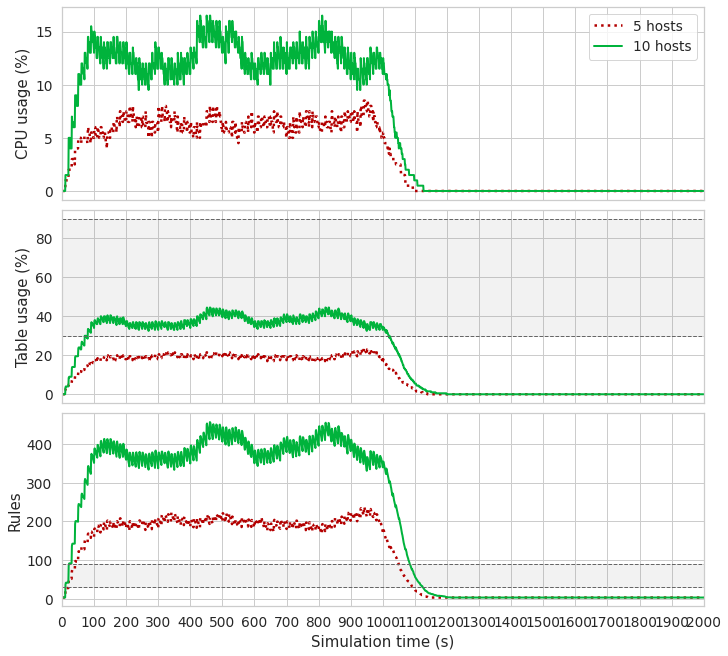

In [7]:
# Criando a figura com seus gráficos e eixo x compartilhado
fig = plt.figure (figsize=(10, 9), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=3, height_ratios=[1, 1, 1])
ax_tab = fig.add_subplot(spec[2])
ax_cpu = fig.add_subplot(spec[1], sharex=ax_tab)
ax_tft = fig.add_subplot(spec[0], sharex=ax_tab)

df_5 = df_hwstats.query ("Carga == '5hosts'")
df_10 = df_hwstats.query ("Carga == '10hosts'")

# Linha para o uso de CPU de cada carga
ax_tft.plot ("TimeSec", "LoaUsag", ":",  data=df_5, color="#b30000", label="5 hosts", linewidth=2.5)
ax_tft.plot ("TimeSec", "LoaUsag", "-",  data=df_10, color="#00b33c", label="10 hosts")
  
# Linha para o uso de tabela de cada carga
ax_cpu.plot ("TimeSec", "FloUsag", ":",  data=df_5, color="#b30000", label="5 hosts", linewidth=2.5)
ax_cpu.plot ("TimeSec", "FloUsag", "-",  data=df_10, color="#00b33c", label="10 hosts")


# Thresholds de uso de tabela
ax_cpu.axhspan (ymin=30, ymax=90, color='gray', alpha=0.1)
ax_cpu.axhline (y=30, color="#666666", lw=1, ls="--")
ax_cpu.axhline (y=90, color="#666666", lw=1, ls="--")

# Linha para o numero de regras de cada carga
ax_tab.plot ("TimeSec", "FloEntr", ":",  data=df_5, color="#b30000", label="5 hosts", linewidth=2.5)
ax_tab.plot ("TimeSec", "FloEntr", "-",  data=df_10, color="#00b33c", label="10 hosts")

# Thresholds de uso de tabela
ax_tab.axhspan (ymin=30, ymax=90, color='gray', alpha=0.1)
ax_tab.axhline (y=30, color="#666666", lw=1, ls="--")
ax_tab.axhline (y=90, color="#666666", lw=1, ls="--")
    
# Ajuste do eixo y
ax_tft.set_ylabel ("CPU usage (%)", )
ax_cpu.set_ylabel ("Table usage (%)")
ax_tab.set_ylabel ("Rules")
# ax_tft.set_ylim (0.8, 4.2)
# ax_tft.set_ylim (0.9, 4.1)
# ax_cpu.set_ylim (0, 100)
# ax_tab.set_ylim (0, 100)
# ax_tft.set_yticks ([1, 2, 3, 4])
# ax_tft.set_yticklabels (["1", "2", "", "4"])
# ax_cpu.set_yticks (range (0, 101, 25))
# ax_tab.set_yticks (range (0, 101, 25))

# Ajuste do eixo x
ax_tab.set_xlabel ("Simulation time (s)")
ax_tft.tick_params (labelbottom=False)
ax_cpu.tick_params (labelbottom=False)
ax_tab.set_xticks (np.arange(0, t_sim + 1, 100))
ax_tab.set_xlim (0, t_sim)

# Legendas
order = [0, 1]
handles, labels = ax_tft.get_legend_handles_labels()
ax_tft.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper right')
   
# Finalizando e retornando a figura
plt.show ()

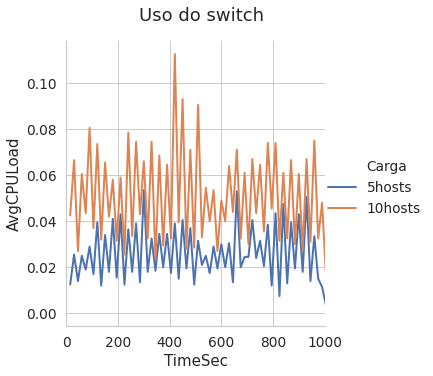

In [8]:
snsplt = sns.relplot(x="TimeSec", y="AvgCPULoad",
            hue="Carga",
            kind="line", legend="full", data=df_plot, ci=None)
snsplt.fig.suptitle('Uso do switch', y=1.05)
snsplt.set(xlim=(0,1000))

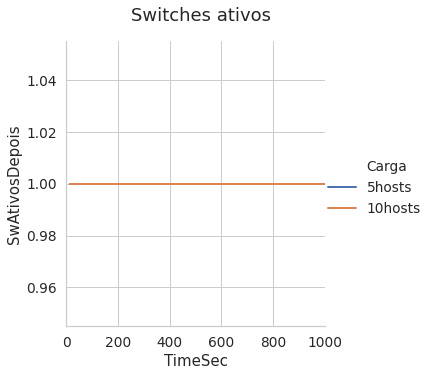

In [9]:
snsplt = sns.relplot(x="TimeSec", y="SwAtivosDepois",
            hue="Carga",
            kind="line", legend="full", data=df_plot, ci=None)
snsplt.fig.suptitle('Switches ativos', y=1.05)
snsplt.set(xlim=(0,1000))

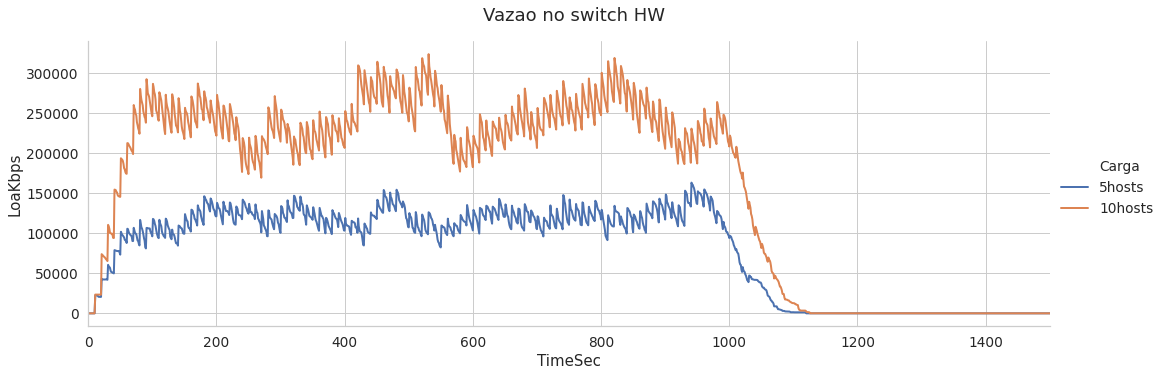

In [10]:
snsplt = sns.relplot(x="TimeSec", y="LoaKbps",
            hue="Carga",
            kind="line", legend="full", data=df_hwstats, ci=None, aspect=3)
snsplt.fig.suptitle('Vazao no switch HW', y=1.05)
snsplt.set(xlim=(0,1500))

In [11]:
#Lendo os arquivos de ping
df_ping = []
agg_mapping = {'time' : np.mean}
for carga in cargas:
    df_sed = []
    for seed in seeds:
        df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+carga+"-"+str(seed)+"-pingHW.log", sep='\s+', index_col=["seq"])
        df['Switch'] = "HW"
        df_sed.append (df)
        df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+carga+"-"+str(seed)+"-pingSW.log", sep='\s+', index_col=["seq"])
        df['Switch'] = "SW"
        df_sed.append (df)
    df_ping.append (pd.concat (df_sed).groupby (["seq", "Switch"]).agg (agg_mapping))
df_pingstats = pd.concat (df_ping, keys=cargas, names=["Carga"], copy=False)
df_pingstats = df_pingstats.reset_index ()
# df_pingstats

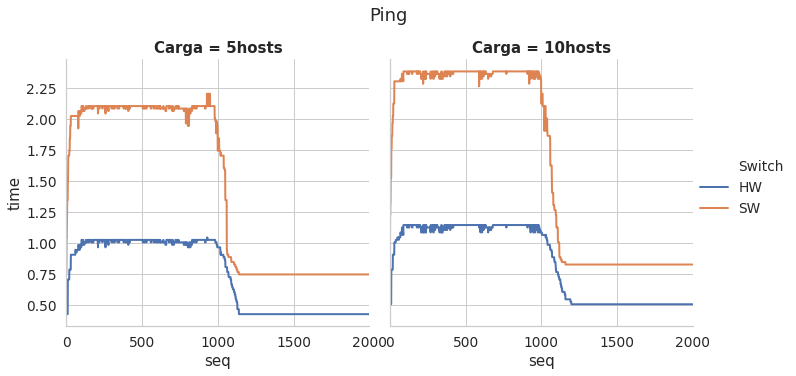

In [12]:
snsplt = sns.relplot(x="seq", y="time",
           hue="Switch", col="Carga",
           kind="line", legend="full", data=df_pingstats, ci=None)
snsplt.fig.suptitle('Ping', y=1.05)
snsplt.set(xlim=(0,2000))

In [13]:
df_sw = []
agg_mapsw = {'LoaUsag' : np.mean, 'FloUsag' : np.mean, 'FloEntr' : np.mean,'Packets' : mymode, 'LoaDrps' : mymode}
for carga in cargas:
    df_sed = []
    for seed in seeds:
        df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+carga+"-"+str(seed)+"-switch-stats-sw1.log", sep='\s+', index_col=["TimeSec"])
        df_sed.append (df)
    df_sw.append (pd.concat (df_sed).groupby (["TimeSec"]).agg (agg_mapsw))
df_swstats = pd.concat (df_sw, keys=cargas, names=["Carga"], copy=False)
df_swstats = df_swstats.reset_index ()
df_swstats["%drop"] = df_swstats["LoaDrps"]/(df_swstats["Packets"]+df_swstats["LoaDrps"])
df_swstats

,Carga,TimeSec,LoaUsag,FloUsag,FloEntr,Packets,LoaDrps,%drop
0,5hosts,1.0,0.0,0.0,3.0,0,0,NaN
1,5hosts,2.0,0.0,0.0,4.0,101,0,0.0
2,5hosts,3.0,0.0,0.0,6.5,255,0,0.0
3,5hosts,4.0,1.0,0.0,9.0,311,0,0.0
4,5hosts,5.0,1.0,0.0,10.5,475,0,0.0
5,5hosts,6.0,1.5,0.0,13.0,925,0,0.0
6,5hosts,7.0,2.0,0.0,17.5,1211,0,0.0
7,5hosts,8.0,2.5,0.0,20.5,1436,0,0.0
8,5hosts,9.0,3.0,0.0,23.0,1562,0,0.0
9,5hosts,10.0,3.0,0.0,26.0,1773,0,0.0


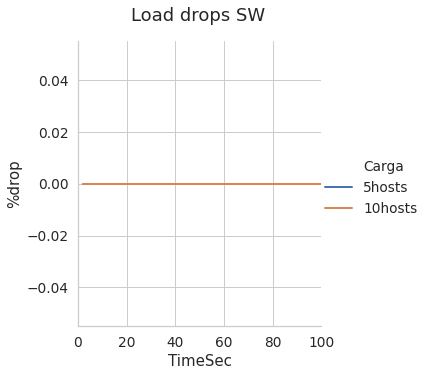

In [14]:
snsplt = sns.relplot(x="TimeSec", y="%drop",
            hue="Carga",
            kind="line", legend="full", data=df_swstats, ci=None)
snsplt.fig.suptitle('Load drops SW', y=1.05)
snsplt.set(xlim=(0,100))

In [15]:
df_bloq = []
agg_mapbloq = {'RegrasAceitas' : np.mean, 'RegrasBloqueadas' : np.mean}
for carga in cargas:
    df_sed = []
    for seed in seeds:
        df = pd.read_csv ("saidas/"+carga+"/seed"+str(seed)+"/"+carga+"-"+str(seed)+"-statistics.log", sep='\s+', index_col=["TimeSec"])
        df_sed.append (df)
    df_bloq.append (pd.concat (df_sed).groupby (["TimeSec"]).agg (agg_mapbloq))
df_bloqstats = pd.concat (df_bloq, keys=cargas, names=["Carga"], copy=False)
df_bloqstats = df_bloqstats.reset_index ()
df_bloqstats["%block"] = df_bloqstats["RegrasBloqueadas"]/(df_bloqstats["RegrasAceitas"]+df_bloqstats["RegrasBloqueadas"])
df_bloqstats

,Carga,TimeSec,RegrasAceitas,RegrasBloqueadas,%block
0,5hosts,1.0,0.0,0,NaN
1,5hosts,2.0,1.5,0,0.0
2,5hosts,3.0,4.0,0,0.0
3,5hosts,4.0,1.5,0,0.0
4,5hosts,5.0,1.5,0,0.0
5,5hosts,6.0,3.5,0,0.0
6,5hosts,7.0,4.5,0,0.0
7,5hosts,8.0,2.5,0,0.0
8,5hosts,9.0,2.0,0,0.0
9,5hosts,10.0,3.5,0,0.0


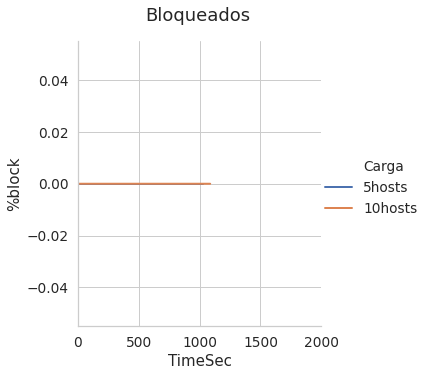

In [16]:
snsplt = sns.relplot(x="TimeSec", y="%block",
            hue="Carga",
            kind="line", legend="full", data=df_bloqstats, ci=None)
snsplt.fig.suptitle('Bloqueados', y=1.05)
snsplt.set(xlim=(0,2000))